In [1]:
!kaggle datasets download -d jaidalmotra/weed-detection

Dataset URL: https://www.kaggle.com/datasets/jaidalmotra/weed-detection
License(s): CC-BY-NC-SA-4.0
 95% 148M/156M [00:01<00:00, 126MB/s]
100% 156M/156M [00:01<00:00, 102MB/s]


In [2]:
!unzip /content/weed-detection.zip


Archive:  /content/weed-detection.zip
  inflating: test/_annotations.coco.json  
  inflating: test/ridderzuring_3109_jpg.rf.b8e99770acf95370b238f2af2a71f5a3.jpg  
  inflating: test/ridderzuring_3123_jpg.rf.dec89676b33f976690aabf25128a32ae.jpg  
  inflating: test/ridderzuring_3126_jpg.rf.8980b3ae3ec4ecd023aab5bc54c26089.jpg  
  inflating: test/ridderzuring_3128_jpg.rf.3df60a441016955fbf62fc335db58f9d.jpg  
  inflating: test/ridderzuring_3129_jpg.rf.d376edabc61dc552b7f6671377a0ec98.jpg  
  inflating: test/ridderzuring_3132_jpg.rf.3e9ea76cf7c71c600deb988d67eac2ad.jpg  
  inflating: test/ridderzuring_3133_jpg.rf.5c8cd3580345823bfdc4fea6b7c4a55b.jpg  
  inflating: test/ridderzuring_3134_jpg.rf.33c8c3b64b84bc37707d1ae492358041.jpg  
  inflating: test/ridderzuring_3136_jpg.rf.e6dfee17f1b34aec0eb6f5db5c0a8743.jpg  
  inflating: test/ridderzuring_3137_jpg.rf.45eb60ce06dae131686009b7d33066e5.jpg  
  inflating: test/ridderzuring_3140_jpg.rf.1bb92c730b1b7f7053fae4c7b38de457.jpg  
  inflating: test

In [3]:
import os
import json
import numpy as np
from PIL import Image
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

class ObjectDetectionDataset(Dataset):
    def __init__(self, json_file, images_dir):
        self.images_dir = images_dir

        with open(json_file, 'r') as file:
            self.data = json.load(file)

        self.images = self.data['images']
        self.annotations = self.data['annotations']
        self.categories = self.data['categories']

        self.transform = transforms.Compose([
            transforms.ToTensor()
        ])

    def __len__(self):
        return len(self.images)

    def __getitem__(self, index):
        image_info = self.images[index]
        image_id = image_info['id']
        image_path = os.path.join(self.images_dir, image_info['file_name'])

        # Load the image
        image = Image.open(image_path).convert('RGB')

        # Convert the image to a tensor
        image = self.transform(image)

        # Get all annotations for the current image
        image_annotations = [ann for ann in self.annotations if ann['image_id'] == image_id]

        # Extract bounding boxes, class labels, and areas
        bboxes = []
        labels = []
        areas = []
        for ann in image_annotations:
            bbox = ann['bbox']
            # Convert bbox to [x_min, y_min, x_max, y_max]
            x_min, y_min, width, height = bbox
            x_max = x_min + width
            y_max = y_min + height

            # Check for valid bounding box dimensions
            if width > 0 and height > 0:
                bboxes.append([x_min, y_min, x_max, y_max])
                labels.append(ann['category_id'])
                areas.append(ann['area'])

        # If no valid bounding boxes, skip this sample
        if len(bboxes) == 0:
            return None

        # Convert to tensors
        bboxes = torch.as_tensor(bboxes, dtype=torch.float32)
        labels = torch.as_tensor(labels, dtype=torch.int64)
        areas = torch.as_tensor(areas, dtype=torch.float32)

        return image, bboxes, labels, areas


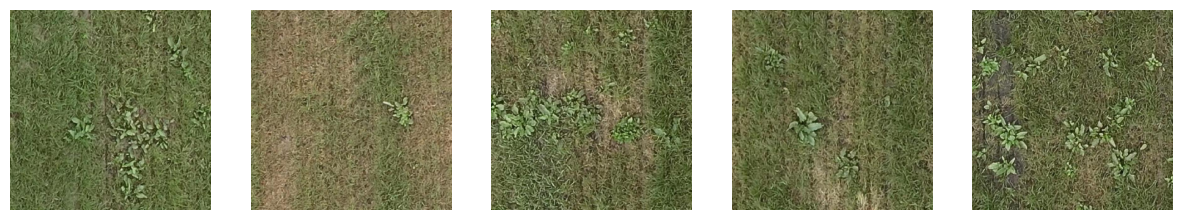

In [8]:
from PIL import Image, ImageDraw
import matplotlib.pyplot as plt
def show_images(dataset, num_images=5):
    fig, axs = plt.subplots(1, num_images, figsize=(15, 5))
    for i in range(num_images):
        image, bboxes, labels, _ = dataset[i]
        image = transforms.ToPILImage()(image)
        draw = ImageDraw.Draw(image)
        axs[i].imshow(image)
        axs[i].axis('off')
    plt.show()

val_dataset = ObjectDetectionDataset('/content/test/_annotations.coco.json', 'test')

show_images(val_dataset, num_images=5)



In [ ]:
def collate_fn(batch):
    batch = list(filter(lambda x: x is not None, batch))
    images, bboxes, labels, areas = zip(*batch)

    images = torch.stack(images, dim=0)

    return images, bboxes, labels, areas

# Function to get the model
def get_model_instance_segmentation(num_classes):
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(weights='COCO_V1')
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
    return model

In [5]:

dataset = ObjectDetectionDataset('train/_annotations.coco.json', 'train')
dataloader = DataLoader(dataset, batch_size=2, shuffle=True, num_workers=2, collate_fn=collate_fn)

# Device configuration
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')


num_classes = len(dataset.categories) + 1


model = get_model_instance_segmentation(num_classes)
model.to(device)


params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

# Training loop
num_epochs =2
for epoch in range(num_epochs):
    model.train()
    i = 0
    for images, bboxes, labels, areas in dataloader:
        images = [image.to(device) for image in images]
        targets = []
        for j in range(len(bboxes)):
            targets.append({
                'boxes': bboxes[j].to(device),
                'labels': labels[j].to(device),
                'image_id': torch.tensor([j], device=device),
                'area': areas[j].to(device),
                'iscrowd': torch.zeros_like(labels[j], device=device)
            })

        loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())

        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

        i += 1
        if i % 50 == 0:
            print(f"Epoch: {epoch+1}, Step: {i}, Loss: {losses.item()}")

    lr_scheduler.step()

# Save the model
torch.save(model.state_dict(), 'faster_rcnn_model.pth')


Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth
100%|██████████| 160M/160M [00:02<00:00, 72.5MB/s]
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch: 1, Step: 50, Loss: 0.6778319478034973
Epoch: 1, Step: 100, Loss: 0.3630284070968628
Epoch: 1, Step: 150, Loss: 0.5055558681488037
Epoch: 1, Step: 200, Loss: 0.9688408374786377
Epoch: 1, Step: 250, Loss: 0.3859504759311676
Epoch: 1, Step: 300, Loss: 0.431925505399704
Epoch: 1, Step: 350, Loss: 0.24030205607414246
Epoch: 1, Step: 400, Loss: 0.3938419222831726
Epoch: 1, Step: 450, Loss: 0.6730490922927856
Epoch: 1, Step: 500, Loss: 0.3625645935535431
Epoch: 1, Step: 550, Loss: 0.37175625562667847
Epoch: 1, Step: 600, Loss: 0.3099271357059479
Epoch: 1, Step: 650, Loss: 0.28603801131248474
Epoch: 1, Step: 700, Loss: 0.6988073587417603
Epoch: 1, Step: 750, Loss: 0.7335100173950195
Epoch: 1, Step: 800, Loss: 0.21286416053771973
Epoch: 2, Step: 50, Loss: 0.17901143431663513
Epoch: 2, Step: 100, Loss: 0.3576752543449402
Epoch: 2, Step: 150, Loss: 0.3261879086494446
Epoch: 2, Step: 200, Loss: 0.30626070499420166
Epoch: 2, Step: 250, Loss: 0.16349585354328156
Epoch: 2, Step: 300, Loss: 0.1

In [6]:
import os
import json
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from PIL import Image
from pycocotools.coco import COCO
from pycocotools.cocoeval import COCOeval

class ObjectDetectionDataset(Dataset):
    def __init__(self, json_file, images_dir):
        self.images_dir = images_dir
        with open(json_file, 'r') as file:
            self.data = json.load(file)
        self.images = self.data['images']
        self.annotations = self.data['annotations']
        self.categories = self.data['categories']
        self.transform = transforms.Compose([transforms.ToTensor()])

    def __len__(self):
        return len(self.images)

    def __getitem__(self, index):
        image_info = self.images[index]
        image_id = image_info['id']
        image_path = os.path.join(self.images_dir, image_info['file_name'])
        image = Image.open(image_path).convert('RGB')
        image = self.transform(image)
        image_annotations = [ann for ann in self.annotations if ann['image_id'] == image_id]
        bboxes = []
        labels = []
        areas = []
        for ann in image_annotations:
            bbox = ann['bbox']
            x_min, y_min, width, height = bbox
            x_max = x_min + width
            y_max = y_min + height
            if width > 0 and height > 0:
                bboxes.append([x_min, y_min, x_max, y_max])
                labels.append(ann['category_id'])
                areas.append(ann['area'])
        if len(bboxes) == 0:
            return None
        bboxes = torch.as_tensor(bboxes, dtype=torch.float32)
        labels = torch.as_tensor(labels, dtype=torch.int64)
        areas = torch.as_tensor(areas, dtype=torch.float32)
        return image, bboxes, labels, areas

def collate_fn(batch):
    batch = list(filter(lambda x: x is not None, batch))
    images, bboxes, labels, areas = zip(*batch)
    images = torch.stack(images, dim=0)
    return images, bboxes, labels, areas

def get_model_instance_segmentation(num_classes):
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(weights='COCO_V1')
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
    return model

def evaluate_model(model, dataloader, device):
    model.eval()
    results = []
    with torch.no_grad():
        for images, bboxes, labels, areas in dataloader:
            images = [image.to(device) for image in images]
            outputs = model(images)
            for i, output in enumerate(outputs):
                image_id = i  # Adjust based on your implementation
                boxes = output['boxes'].cpu().numpy()
                scores = output['scores'].cpu().numpy()
                labels = output['labels'].cpu().numpy()
                for box, score, label in zip(boxes, scores, labels):
                    results.append({
                        'image_id': image_id,
                        'category_id': label,
                        'bbox': box.tolist(),
                        'score': score
                    })
    return results

# Load datasets
val_dataset = ObjectDetectionDataset('/content/test/_annotations.coco.json', 'test')
val_dataloader = DataLoader(val_dataset, batch_size=2, shuffle=False, num_workers=2, collate_fn=collate_fn)

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

num_classes = len(val_dataset.categories) + 1

# Get the model
model = get_model_instance_segmentation(num_classes)
model.to(device)
model.load_state_dict(torch.load('faster_rcnn_model.pth'))

# Evaluate the model
results = evaluate_model(model, val_dataloader, device)

coco_gt = COCO('/content/test/_annotations.coco.json')

# Convert results to COCO format
coco_dt = coco_gt.loadRes(results)

coco_eval = COCOeval(coco_gt, coco_dt, iouType='bbox')

#  evaluation
coco_eval.evaluate()
coco_eval.accumulate()
coco_eval.summarize()


loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.07s).
Accumulating evaluation results...
DONE (t=0.02s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets

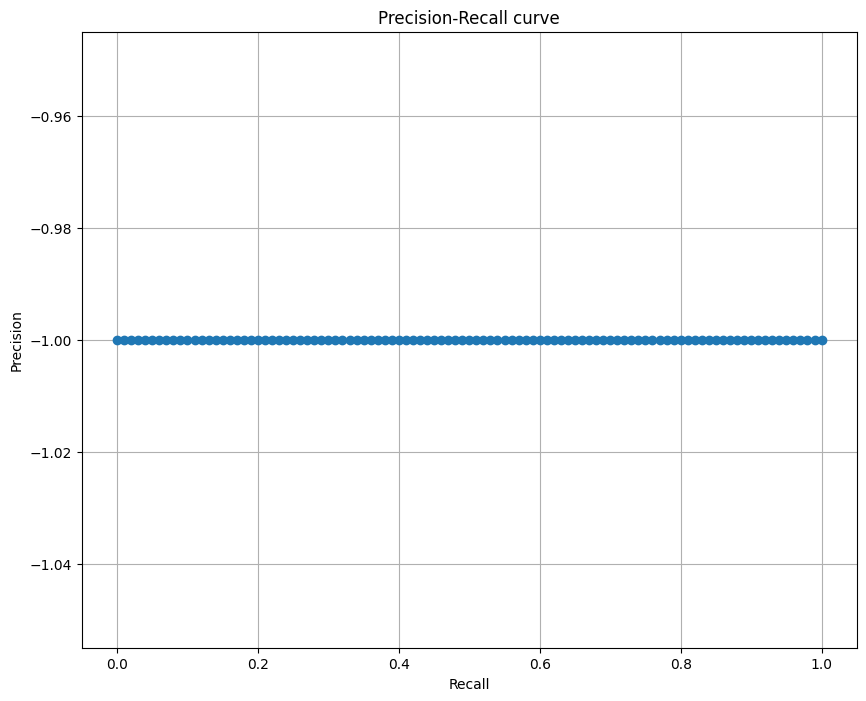

In [8]:
import matplotlib.pyplot as plt
import numpy as np

precision = coco_eval.eval['precision']
category_index = 0
iou_index = 0
precision_recall = precision[iou_index, :, category_index, 0, -1]

plt.figure(figsize=(10, 8))
plt.plot(np.linspace(0.0, 1.0, len(precision_recall)), precision_recall, marker='o')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall curve')
plt.grid(True)
plt.show()


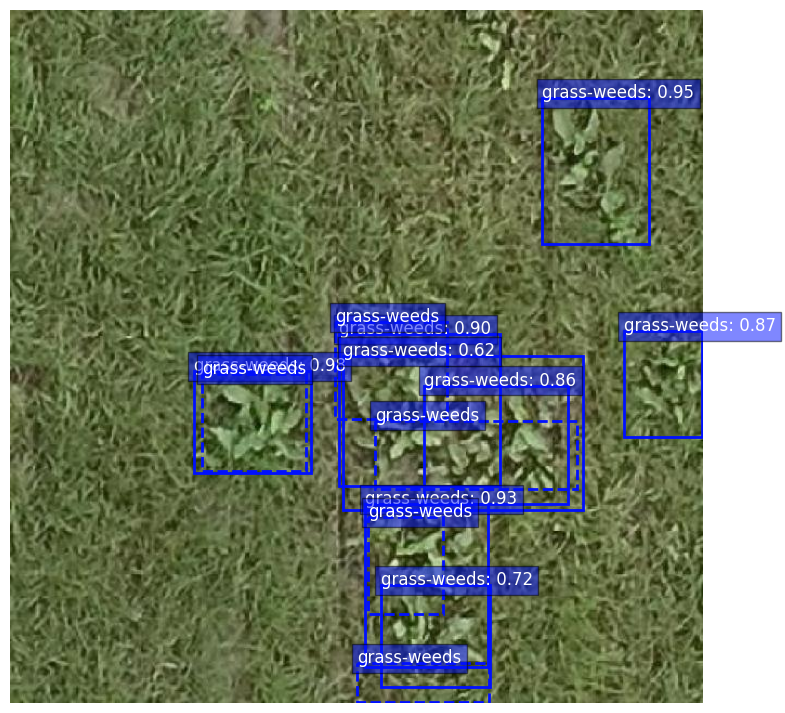

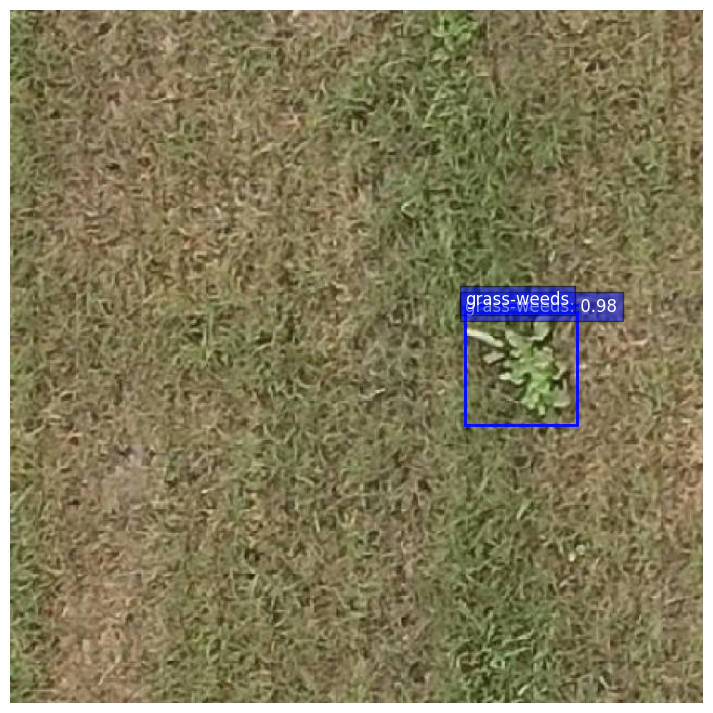

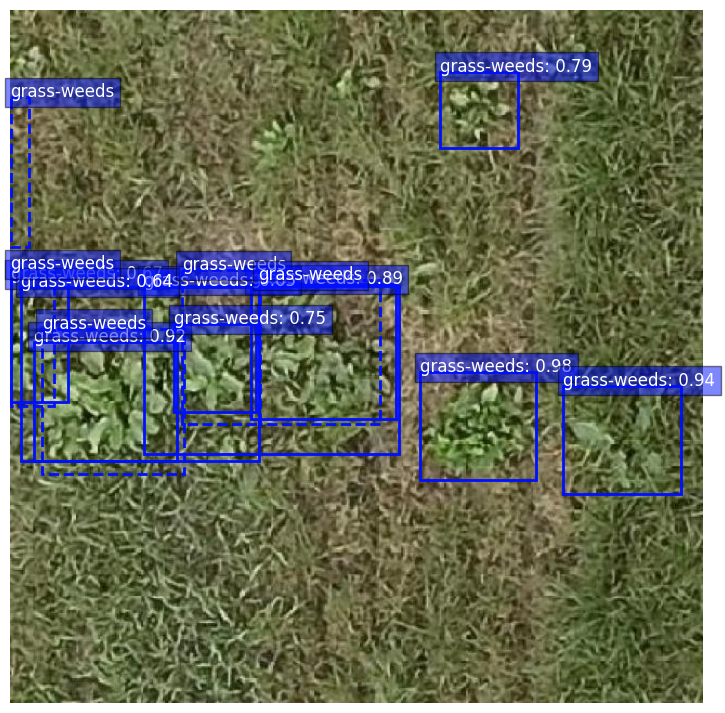

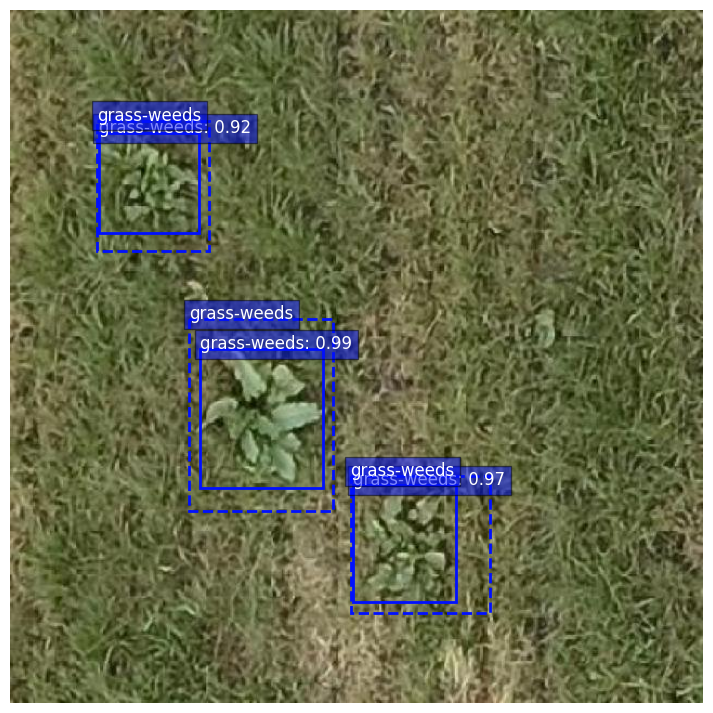

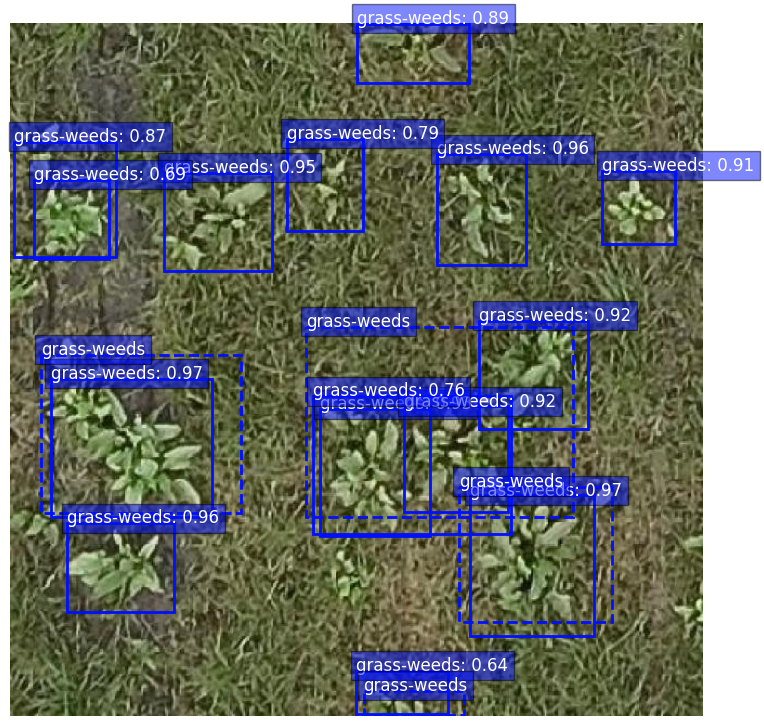

In [10]:
def visualize_predictions(dataset, model, device, num_images=5):
    model.eval()
    transform = dataset.transform
    for idx in range(num_images):
        image_info = dataset.images[idx]
        image_id = image_info['id']
        image_path = os.path.join(dataset.images_dir, image_info['file_name'])
        image = Image.open(image_path).convert('RGB')
        image_tensor = transform(image).unsqueeze(0).to(device)

        with torch.no_grad():
            output = model(image_tensor)

        fig, ax = plt.subplots(1, 1, figsize=(12, 9))
        ax.imshow(image)
        colors = sns.color_palette('hsv', len(dataset.categories))

        # Plot predicted boxes
        boxes = output[0]['boxes'].cpu().numpy()
        scores = output[0]['scores'].cpu().numpy()
        labels = output[0]['labels'].cpu().numpy()
        for box, score, label in zip(boxes, scores, labels):
            if score > 0.5:  # Show only high confidence predictions
                color = colors[label % len(colors)]
                ax.add_patch(plt.Rectangle((box[0], box[1]), box[2] - box[0], box[3] - box[1],
                                           fill=False, color=color, linewidth=2))
                ax.text(box[0], box[1], f'{dataset.categories[label-1]["name"]}: {score:.2f}',
                        bbox=dict(facecolor=color, alpha=0.5), fontsize=12, color='white')

        # Plot ground truth boxes
        image_annotations = [ann for ann in dataset.annotations if ann['image_id'] == image_id]
        for ann in image_annotations:
            box = ann['bbox']
            x_min, y_min, width, height = box
            x_max = x_min + width
            y_max = y_min + height
            color = colors[ann['category_id'] % len(colors)]
            ax.add_patch(plt.Rectangle((x_min, y_min), width, height,
                                       fill=False, edgecolor=color, linewidth=2, linestyle='--'))
            ax.text(x_min, y_min, dataset.categories[ann['category_id']-1]['name'],
                    bbox=dict(facecolor=color, alpha=0.5), fontsize=12, color='white')

        plt.axis('off')
        plt.show()

# Visualize sample predictions
visualize_predictions(val_dataset, model, device, num_images=5)
